In [2]:
import jupyter_black

import os, random
import numpy as np
import matplotlib.pyplot as plt

jupyter_black.load()

In [3]:
import sys

if "/usr/src" not in sys.path:
    sys.path.append("/usr/src")

In [4]:
# Import torch modules

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

In [13]:
# Import custom modules

import utils
import data.prepare_cells as pc

from model.vae import VAE

In [8]:
cells_dir = "/usr/src/data/bacterias/separated_cells"
test_cells_dir = "/usr/src/data/bacterias/test"

In [9]:
transform = transforms.Compose(
    [transforms.ToPILImage(), pc.CellPadResize(56), transforms.ToTensor()]
)

dataset = pc.CellsImageDataset(cells_dir, transform=transform)

In [16]:
# SETTINGS

test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
NUM_EPOCHS = 50
BATCH_SIZE = 64
IMAGE_SIZE = 56

print("Train sample's size =", train_size)
print("Test sample's size =", test_size)

Train sample's size = 1528
Test sample's size = 382


In [11]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
# Checking the dataset
print("Training Set:")
for images in train_loader:
    print("Image batch dimensions:", images.size())
    break

# Checking the dataset
print("\nTesting Set:")
for images in test_loader:
    print("Image batch dimensions:", images.size())
    break

Training Set:
Image batch dimensions: torch.Size([64, 1, 56, 56])

Testing Set:
Image batch dimensions: torch.Size([64, 1, 56, 56])


In [17]:
utils.set_all_seeds(RANDOM_SEED)

model = VAE(IMAGE_SIZE, DEVICE)
model.to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

VAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=1024, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (z_mean): Linear(in_features=256, out_features=2, bias=True)
  (z_log_var): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=1024, out_features=3136, bias=True)
    (5): Reshape()
    (6): Sigmoid()
  )
)


In [18]:
# Chechout dimensions for stupid me !!!

with torch.no_grad():
    for batch in train_loader:
        print(batch.shape)
        wtf = model.encoder(batch.to(DEVICE))
        print(wtf.shape)

        z_mean, z_log_var = model.z_mean(wtf), model.z_log_var(wtf)
        encoded = model.reparameterize(z_mean, z_log_var)
        print(z_mean.shape, z_log_var.shape)
        print(encoded.shape)

        decoded_wtf = model.decoder(encoded)
        print(decoded_wtf.shape)
        break

torch.Size([64, 1, 56, 56])
torch.Size([64, 256])
torch.Size([64, 2]) torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 1, 56, 56])


In [19]:
import time

log_dict = {
    "train_combined_loss_per_batch": [],
    "train_combined_loss_per_epoch": [],
    "train_reconstruction_loss_per_batch": [],
    "train_kl_loss_per_batch": [],
}

loss_fn = nn.functional.mse_loss

reconstruction_term_weight = 1
logging_interval = 6

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()

    for batch_idx, features in enumerate(train_loader):
        features = features.to(DEVICE)

        # forward and backprop
        encoded, z_mean, z_log_var, decoded = model(features)

        # total loss = reconstruction loss + KL divergence
        # kl_divergence = (0.5 * (z_mean**2 +
        #                        torch.exp(z_log_var) - z_log_var - 1)).sum()

        kl_div = -0.5 * torch.sum(
            1 + z_log_var - z_mean**2 - torch.exp(z_log_var), axis=1
        )  # type: ignore # sum over latent dimension

        batchsize = kl_div.size(0)
        kl_div = kl_div.mean()  # average over batch dimension

        pixelwise = loss_fn(decoded, features, reduction="none")
        pixelwise = pixelwise.view(batchsize, -1).sum(axis=1)  # type: ignore # sum over pixels
        pixelwise = pixelwise.mean()  # average over batch dimension

        loss = reconstruction_term_weight * pixelwise + kl_div

        optimizer.zero_grad()

        loss.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        log_dict["train_combined_loss_per_batch"].append(loss.item())
        log_dict["train_reconstruction_loss_per_batch"].append(pixelwise.item())
        log_dict["train_kl_loss_per_batch"].append(kl_div.item())

        if not batch_idx % logging_interval:
            print(
                "Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f"
                % (epoch + 1, NUM_EPOCHS, batch_idx, len(train_loader), loss)
            )

    print("Time elapsed: %.2f min" % ((time.time() - start_time) / 60))

print("Total Training Time: %.2f min" % ((time.time() - start_time) / 60))

Epoch: 001/050 | Batch 0000/0024 | Loss: 591.5756
Epoch: 001/050 | Batch 0006/0024 | Loss: 323.9417
Epoch: 001/050 | Batch 0012/0024 | Loss: 244.2242
Epoch: 001/050 | Batch 0018/0024 | Loss: 226.2431
Time elapsed: 0.04 min
Epoch: 002/050 | Batch 0000/0024 | Loss: 199.0605
Epoch: 002/050 | Batch 0006/0024 | Loss: 171.9395
Epoch: 002/050 | Batch 0012/0024 | Loss: 189.3674
Epoch: 002/050 | Batch 0018/0024 | Loss: 193.2634
Time elapsed: 0.07 min
Epoch: 003/050 | Batch 0000/0024 | Loss: 163.4983
Epoch: 003/050 | Batch 0006/0024 | Loss: 187.6362
Epoch: 003/050 | Batch 0012/0024 | Loss: 193.1385
Epoch: 003/050 | Batch 0018/0024 | Loss: 147.7974
Time elapsed: 0.11 min
Epoch: 004/050 | Batch 0000/0024 | Loss: 127.8002
Epoch: 004/050 | Batch 0006/0024 | Loss: 178.0120
Epoch: 004/050 | Batch 0012/0024 | Loss: 129.1067
Epoch: 004/050 | Batch 0018/0024 | Loss: 95.6530
Time elapsed: 0.14 min
Epoch: 005/050 | Batch 0000/0024 | Loss: 98.9398
Epoch: 005/050 | Batch 0006/0024 | Loss: 118.7335
Epoch: 005

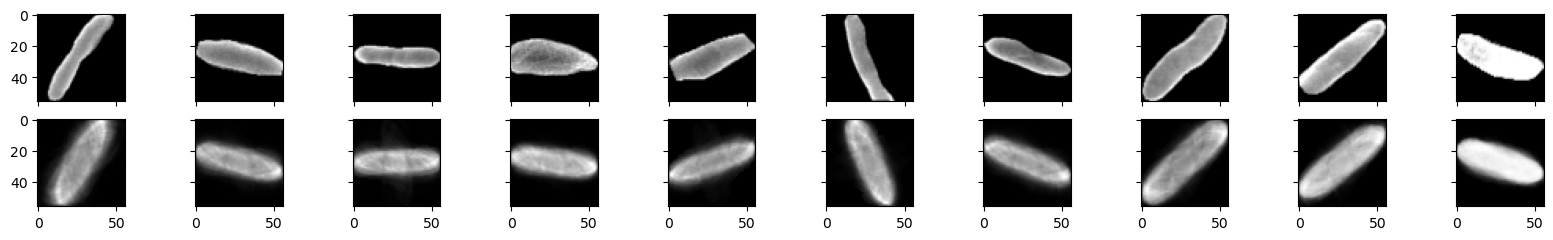

In [20]:
n_images = 10

fig, axes = plt.subplots(2, n_images, sharex=True, sharey=True, figsize=(20, 2.5))

features = next(iter(train_loader))
features = features.to(DEVICE)
color_channels = features.shape[1]
image_height = features.shape[2]
image_width = features.shape[3]

with torch.no_grad():
    encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
orig_images = features[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device("cpu"))
        if color_channels > 1:
            curr_img = np.transpose(curr_img, (1, 2, 0))
            ax[i].imshow(curr_img)
        else:
            ax[i].imshow(curr_img.view((image_height, image_width)), cmap="gray")

In [46]:
some_img = next(iter(test_loader))
with torch.no_grad():
    encoded, z_mean, z_log_var, decoded_images = model(some_img)

In [47]:
some_img.shape, decoded_images.shape

(torch.Size([64, 1, 56, 56]), torch.Size([64, 1, 56, 56]))

In [48]:
first_orig = some_img[0]
first_decoded = decoded_images[0]

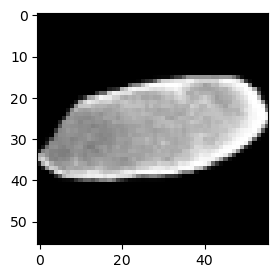

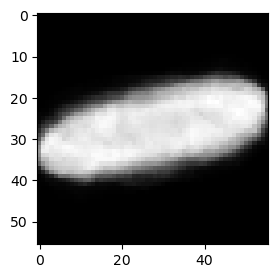

In [51]:
utils.show_image(first_orig)
utils.show_image(first_decoded)